<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 21: Convolutional Neural Networks (CNNs)
### Notebook 6: Adversarial images 

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [1]:
import keras
import numpy as np
import foolbox
import matplotlib.pyplot as plt

# Just in case the Keras defaults aren't as we expect
from keras import backend as K_backend
K_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [3]:
input_dir = file_helper.get_input_data_dir()
sys.path.append(input_dir)
import VGG16_syn_indices
import VGG16_syn_words

In [4]:
# We use the adversarial generator library called Foolbox to make our examples.
# Import all of the Foolbox attacks and criteria, so we can try them all later
# Foolbox documentation at https://foolbox.readthedocs.io/en/latest
from foolbox.attacks import GradientSignAttack, IterativeGradientSignAttack
from foolbox.attacks import GradientAttack, IterativeGradientAttack
from foolbox.attacks import LBFGSAttack
from foolbox.attacks import DeepFoolAttack, SLSQPAttack, SaliencyMapAttack
from foolbox.attacks import SinglePixelAttack, LocalSearchAttack, ApproximateLBFGSAttack
from foolbox.attacks import BoundaryAttack, GaussianBlurAttack
from foolbox.attacks import ContrastReductionAttack, AdditiveUniformNoiseAttack
from foolbox.attacks import AdditiveGaussianNoiseAttack, BlendedUniformNoiseAttack
from foolbox.attacks import SaltAndPepperNoiseAttack
from foolbox.attacks import PrecomputedImagesAttack

from foolbox.criteria import Misclassification, TopKMisclassification, OriginalClassProbability
from foolbox.criteria import TargetClass, TargetClassProbability

In [5]:
def get_models():
    '''Get the Keras and Foolbox models, based on the Foolbox instructions.'''
    keras.backend.set_learning_phase(0) 
    keras_model = keras.applications.vgg16.VGG16(weights='imagenet')
    preprocessing = (np.array([104, 116, 123]), 1)
    fb_model = foolbox.models.KerasModel(keras_model, bounds=(0, 255), preprocessing=preprocessing)
    return keras_model, fb_model

In [6]:
from skimage import io
from skimage.transform import resize

def read_and_prep_image(filepath):
    '''Read in an image, set its type to float32, and return it.'''
    image = io.imread(filepath)
    image = resize(image, (224, 224), order=3, preserve_range=True)
    float_image = image.astype('float32')
    return float_image

In [7]:
def prep_image_for_display(image):
    '''Floating-point images don't display well, and we might be looking
    at images far outside the [0,255] range. So fix them up to look good.'''
    img = np.copy(image)
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 64
    img += 128
    img = np.clip(img, 0, 255).astype('uint8')
    return np.array(img)

In [8]:
def show_float_image(img, filename):
    '''Prep the image, show it, and save it with the given name.'''
    plt.imshow(prep_image_for_display(img))
    plt.xticks([],[])
    plt.yticks([],[])
    file_helper.save_figure(filename)
    plt.show()

In [9]:
def names_from_predictions(predictions, number_to_return):
    '''Get the scores and class names from the list of prediction values.'''
    top_list = []
    for i in range(number_to_return):
        maxarg = np.argmax(predictions)
        maxval = predictions[maxarg]
        top_list.append([maxarg, maxval])
        predictions = [i if i<maxval else -1 for i in predictions]
    report_scores = []
    report_names = []
    for i in top_list:
        n_index = VGG16_syn_indices.syn_indices_list[i[0]]
        words = VGG16_syn_words.syn_words_dict[n_index]
        words = words[:16]  # clip to first 16 chars
        report_scores.append(i[1])
        report_names.append(words)
    return (report_scores, report_names)

In [10]:
def show_adversarial_set(keras_model, 
                         original_image, adversarial_image, delta_image, 
                         number_of_categories, filename):
    '''Plot the original image with scores and classes, the image that we add
    to it (scaled to look good), and then the adversarial image with scores and classes.'''

    original_predictions = keras_model.predict(np.expand_dims(original_image, axis=0))[0]
    (report_scores, report_names) = names_from_predictions(original_predictions, number_of_categories) 
    report_names = [f.split(',')[0] for f in report_names]
    
    fig = plt.figure(figsize=(8,6))
    #fig.subplots_adjust(wspace=0.0)
    
    plt.subplot(2,3,1)
    plt.imshow(prep_image_for_display(original_image))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(2,3,4)
    xs = range(len(report_names))
    plt.bar(xs, report_scores, align='center')
    plt.xticks(xs, report_names, rotation='-90')
    plt.yticks([0,1],[0,1])
    plt.tick_params(axis='x', which='major', labelsize=18)
    
    plt.subplot(2,3,2)    
    plt.imshow(prep_image_for_display(delta_image))
    title = '({:1.2f}, {:1.2f})'.format(np.min(delta_image), np.max(delta_image))
    plt.title(title)
    plt.xticks([],[])
    plt.yticks([],[])
    
    adversarial_predictions = keras_model.predict(np.expand_dims(adversarial_image, axis=0))[0]
    (report_scores, report_names) = names_from_predictions(adversarial_predictions, number_of_categories) 
    report_names = [f.split(',')[0] for f in report_names]
    
    plt.subplot(2,3,3)
    plt.imshow(prep_image_for_display(adversarial_image))
    plt.xticks([],[])
    plt.yticks([],[])
    plt.subplot(2,3,6)
    xs = range(len(report_names))
    plt.bar(xs, report_scores, align='center')
    plt.xticks(xs, report_names, rotation='-90')
    plt.yticks([0,1],[0,1])
    plt.tick_params(axis='x', which='major', labelsize=18)

    plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [11]:
def run_variation(attack_choice, criteria_choice, original_image):
    '''Run an adversarial attack of this type on this image.'''
    attack_val = attack_dict[attack_choice]
    criteria_val = criteria_dict[criteria_choice]
    keras_model, fb_model = get_models()
    
    criteria_func = criteria_val[0]
    criteria_args = criteria_val[1]
    criteria = criteria_func(**criteria_args)
    attacker = attack_val(fb_model, criteria) 

    predictions = keras_model.predict(np.expand_dims(original_image, axis=0))[0]
    # predicted_label is the index of the label, not the label itself, because 
    # of the 2-step process required to work out VGG16 labels, but the distinction 
    # isn't important here because this value is still unique and consistent.
    predicted_label = np.argmax(predictions)

    print('running atttack=',attack_choice,' criteria=',criteria_choice)
    adversarial_image = attacker(image=original_image, label=predicted_label)
    
    delta_image = adversarial_image - original_image    
    print("<<<<<<<<<<< attack was successful! >>>>>>>>>>>>>>>")
    return original_image, adversarial_image, delta_image

In [12]:
# All of the attacks, so we can choose one by name. Note that not all
# attackers work with all criteria. Each attacker/criteria combo takes
# its own amount of time, ranging from seconds to 10's of hours (at least)
attack_dict = {
   'GradientSignAttack': GradientSignAttack,
   'IterativeGradientSignAttack': IterativeGradientSignAttack,
   'GradientAttack': GradientAttack,
   'IterativeGradientAttack': IterativeGradientAttack,
   'LBFGSAttack': LBFGSAttack,
   'DeepFoolAttack': DeepFoolAttack,
   'SLSQPAttack': SLSQPAttack,
   'SaliencyMapAttack': SaliencyMapAttack,
   'SinglePixelAttack': SinglePixelAttack,
   'LocalSearchAttack': LocalSearchAttack,
   'ApproximateLBFGSAttack': ApproximateLBFGSAttack,
   'BoundaryAttack': BoundaryAttack,
   'GaussianBlurAttack': GaussianBlurAttack,
   'ContrastReductionAttack': ContrastReductionAttack,
   'AdditiveUniformNoiseAttack': AdditiveUniformNoiseAttack,
   'AdditiveGaussianNoiseAttack': AdditiveGaussianNoiseAttack,
   'BlendedUniformNoiseAttack': BlendedUniformNoiseAttack,
   'SaltAndPepperNoiseAttack': SaltAndPepperNoiseAttack,
   'PrecomputedImagesAttack': PrecomputedImagesAttack,
}

# All of the attack criteria, so we can choose one by name
# class 864 = tow truck, 870=tricycle
criteria_dict = {
    'Misclassification': [Misclassification, {}],
    'TopKMisclassification': [TopKMisclassification, {'k': 7}],
    'OriginalClassProbability': [OriginalClassProbability, {'p': 0.01}],
    'TargetClass': [TargetClass, {'target_class': 870}],
    'TargetClassProbability': [TargetClassProbability, {'target_class': 870, 'p': 0.98}]
}

In [13]:
def make_and_show_adveraries(attacker, criteria, image_path, single_filname, set_filename):
    '''Run this image through the attack process. Show and save
    the original image, plus the adversarial set. We will use the
    TopKMisclassification criteria, with k=7, so the most likely
    class of the adversarial image won't be one of the top 7 classes
    assigned to the input.'''
    original_image = read_and_prep_image(image_path)
    show_float_image(original_image, single_filname)
    origX, advX, deltaX = run_variation(attacker, criteria, original_image)
    #origX, advX, deltaX = run_variation('BoundaryAttack', 'TopKMisclassification', original_image)
    keras_model, fb_model = get_models()
    show_adversarial_set(keras_model, origX, advX, deltaX, 5, set_filename)

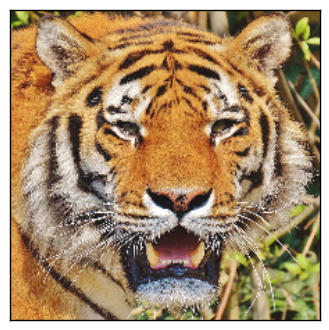

running atttack= GradientSignAttack  criteria= TopKMisclassification
<<<<<<<<<<< attack was successful! >>>>>>>>>>>>>>>


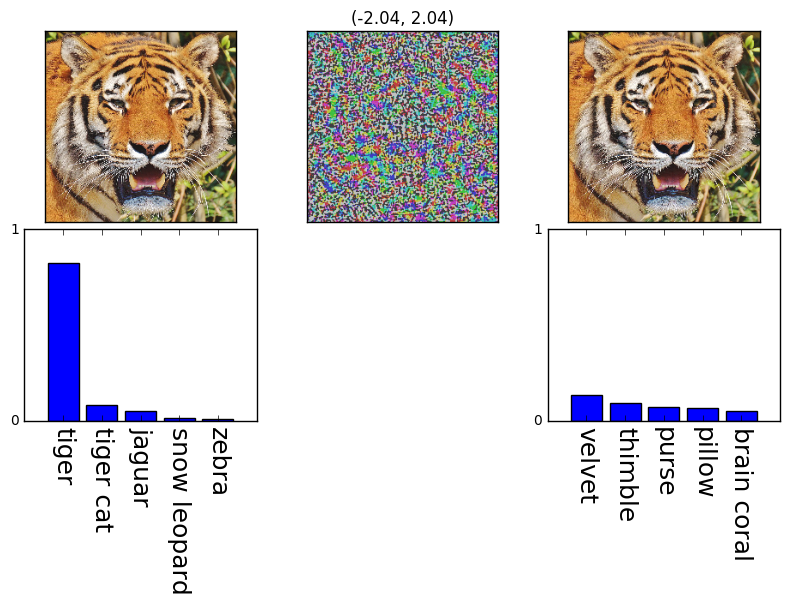

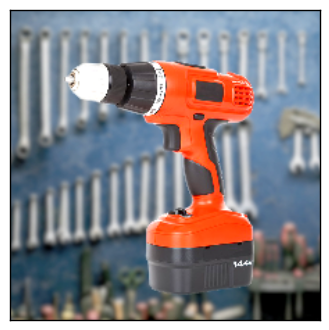

running atttack= GradientSignAttack  criteria= TopKMisclassification
<<<<<<<<<<< attack was successful! >>>>>>>>>>>>>>>


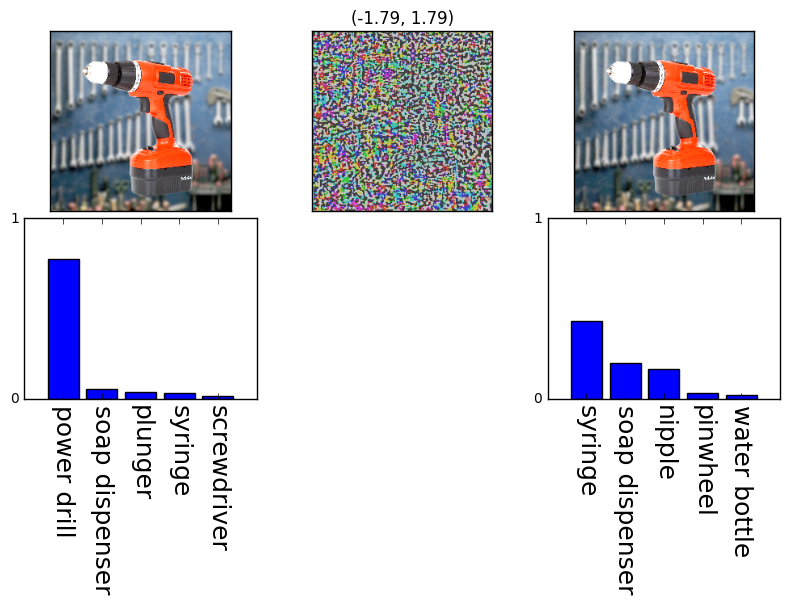

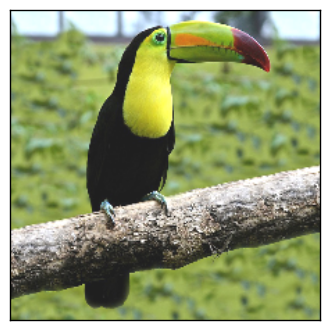

running atttack= GradientSignAttack  criteria= TopKMisclassification
<<<<<<<<<<< attack was successful! >>>>>>>>>>>>>>>


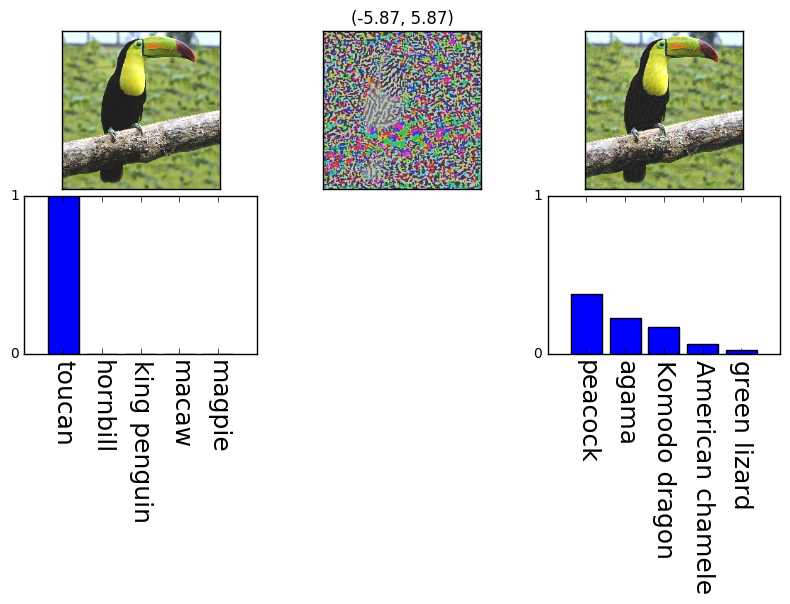

In [14]:
# The images we want to find adversaries for

attacker = 'GradientSignAttack'
criteria = 'TopKMisclassification'

image_files = [
    ['tiger-1342385_640.jpg', 'adv-tiger-original-GSA-TKM', 'adv-tiger-set-GSA-TKM'],
    ['battery-19983_640-sq2.jpg', 'adv-battery-original-GSA-TKM', 'adv-battery-set-GSA-TKM'],
    ['bird-1281886_640-sq.jpg', 'adv-bird-original-GSA-TKM', 'adv-bird-set-GSA-TKM'],
    ]

for (image_name, single_filename, set_filename) in image_files:
    image_path = file_helper.get_input_file_path(image_name)
    make_and_show_adveraries(attacker, criteria, image_path, single_filename, set_filename)